In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('data.csv')
data.dropna(inplace = True)
data

,VISITOR_ID,EVENT,CREATED
3,44cf11c0-1916-4a7a-9742-733c37bad393,pageview,2022-09-27T18:40:29.089023696Z
4,ef91fa1c-bdf8-4464-b210-21476b641dcb,pageview,2022-09-27T17:55:05.283031715Z
5,cf1f040b-dcd5-4e7d-86ff-fe13f18bf267,post-read-mid,2022-09-27T17:19:24.532676373Z
6,5f2c6f11-0bef-4871-b2b8-4eb28a4d003b,pageview,2022-09-27T17:00:25.567739511Z
7,b25aac92-44ea-448b-9ce7-e2aff382a38a,post-read-start,2022-09-27T18:23:14.84872485Z
...,...,...,...
10720296,d8c3f190-d135-4845-8da6-eccfc1017c1e,post-read-end,2022-08-14T08:45:34.89919503Z
10720325,3e2723a0-5a00-47c7-9bba-f8930aef60e0,pageview,2022-06-14T11:57:50.559524056Z
10720326,9ec39687-7ab0-44ec-b1ad-944d6dc61bc2,pageview,2022-06-13T11:31:42.12646514Z
10720327,ffee41a2-795d-4625-bf1d-05ea6db26ff2,pageview,2022-06-15T06:17:35.644775696Z


In [4]:
len(np.unique(data[['VISITOR_ID']]))

1422154

In [5]:
user_seqs = data.sort_values('CREATED').groupby('VISITOR_ID')

In [6]:
users = list(user_seqs.groups.keys())

In [7]:
users_subset = users[:100000]

## IDLE

In [6]:
from datetime import datetime

diff_list = []
for user in users:
    event_times = user_seqs.get_group(user).CREATED
    # Calculating difference list
    for x, y in zip(event_times[0::], event_times[1::]):
        xt = datetime.strptime(' '.join(x.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        yt = datetime.strptime(' '.join(y.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        diff_list.append(yt-xt)

In [7]:
time_gaps = pd.DataFrame({'Time': diff_list})

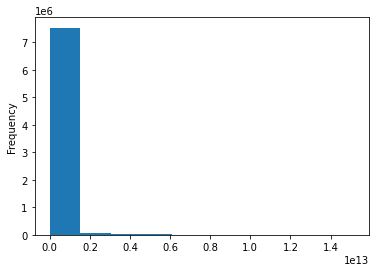

In [8]:
import matplotlib.pyplot as plt
time_gaps = time_gaps.Time.astype('timedelta64[us]')#[time_gaps.Time.astype('timedelta64[s]') > 60*60*24]
time_gaps.plot.hist();

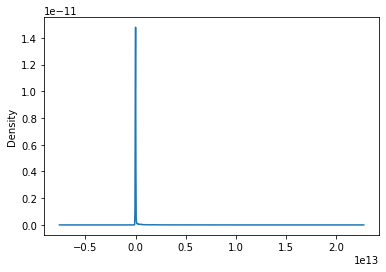

In [9]:
time_gaps.plot.kde();

In [10]:
exp_mean = time_gaps.mean()
print(exp_mean)
lam = 1/exp_mean
lam

88228666236.78455


1.133418471176069e-11

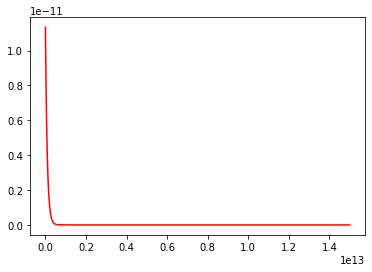

In [11]:
def f(x):
    return lam*np.exp(-lam*x)

x = np.linspace(0, 15000000000000, 1000)

plt.plot(x, f(x), color='red');
#plt.axvline(x = ...)

In [12]:
idle = -exp_mean*np.log(0.05)
idle

264309462898.15878

Assuming the events behave as a Poisson random process (which might be a bit of a bold assumption here...), we can model the time between events as an exponential random variable and approximate its parameter lambda to be the mean of the event gaps. Then, in order to determine the idle period length, let us consider the value corresponding to the 95% quantile of the CDF to be an appropirate choice. This yield 264308.38230286376 as our threshold value for an idle period.

In [13]:
hours = idle/(60*60*1000000)
hours

73.41929524948856

In [14]:
time_gaps.quantile(0.95)

246021834999.9998

## QUIT

In [15]:
#current_time = datetime.now()
current_time = datetime.strptime('2022-12-31 23:59:59.999', '%Y-%m-%d %H:%M:%S.%f')
gap_list = []
for user in users:
    x = user_seqs.get_group(user).CREATED.iloc[-1]
    gap_list.append(current_time - datetime.strptime(' '.join(x.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f'))

In [16]:
qtime_gaps = pd.DataFrame({'Time': gap_list})

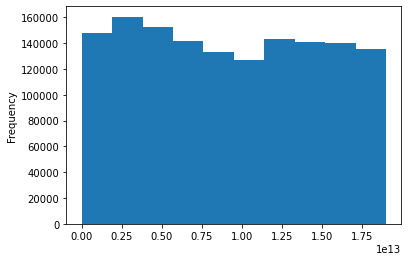

In [17]:
qtime_gaps = qtime_gaps.Time.astype('timedelta64[us]')#[time_gaps.Time.astype('timedelta64[s]') > 60*60*24]
qtime_gaps.plot.hist();

In [18]:
maxdiff_list = []
for user in users:
    event_times = user_seqs.get_group(user).CREATED
    # Calculating difference list
    temp = []
    for x, y in zip(event_times[0::], event_times[1::]):
        xt = datetime.strptime(' '.join(x.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        yt = datetime.strptime(' '.join(y.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        temp.append(yt-xt)
    if temp:
        maxdiff_list.append(np.max(temp))

In [19]:
max_gaps = pd.DataFrame({'Time': maxdiff_list})

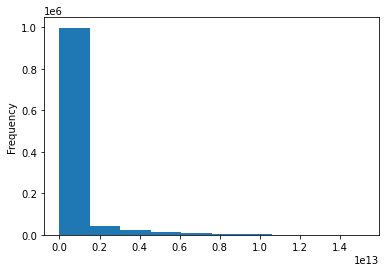

In [20]:
max_gaps = max_gaps.Time.astype('timedelta64[us]')#[time_gaps.Time.astype('timedelta64[s]') > 60*60*24]
max_gaps.plot.hist();

In [21]:
maxexp_mean = max_gaps.mean()
print(exp_mean)
maxlam = 1/maxexp_mean
maxlam

88228666236.78455


2.283312649124008e-12

if end in idle and have end greater than max... or if end is above certain threshold of max...

exclude from training sequences not ending in idle and those final sequences ending in idle but not quit

In [22]:
quit = -maxexp_mean*np.log(0.1)
quit

1008440562827.623

In [23]:
hours = quit/(60*60*1000000)
hours

280.1223785632286

In [24]:
max_gaps.quantile(0.9)

1228457027999.9995

In [25]:
np.sum([max_gaps > quit])/len(max_gaps)

0.11123626198519436

## SEQ

In [185]:
from itertools import compress

# need to add paired array containing returns or quits boolean

# heads up, this cell takes like 30 mins to run...

seqs = []
for user in users:
    event_times = user_seqs.get_group(user).CREATED
    event_seq = list(user_seqs.get_group(user).EVENT)
    diff_list = []
    for x, y in zip(event_times[0::], event_times[1::]):
        xt = datetime.strptime(' '.join(x.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        yt = datetime.strptime(' '.join(y.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        diff_list.append(yt-xt)
    
    diff_list = np.array(diff_list, dtype='timedelta64[us]').astype(float)
    idle_bool = diff_list > idle
    idle_indices = list(compress(range(len(idle_bool)), idle_bool))
    idle_indices = [x+1 for x in idle_indices]
    
    temp = []
    s = idle_indices + [len(event_seq)]
    temp.append([event_seq[i1:i2] for i1,i2 in zip([0]+s[:-1], s)])
    
    [seqs.append(np.array(item, dtype=object)) for item in temp[0]]
    
seqs = np.array(seqs, dtype=object)

In [86]:
# something started going wrong here.... not sure why

# Use vectorize function of numpy
length_checker = np.vectorize(len)
 
# Find the length of each element
#seq_lens = length_checker(seqs)

In [187]:
seq_lens = [len(seq) for seq in seqs]

In [188]:
lens = pd.DataFrame({'Lengths': seq_lens})

In [189]:
pd.set_option('display.max_rows', 100)
lens.Lengths.value_counts().sort_index()[:100]

1      393075
2       79953
3       65430
4      868946
5       58807
6       23853
7       16549
8      131890
9       21374
10       9979
11       7025
12      36011
13       8824
14       4823
15       3522
16      13532
17       4308
18       2564
19       2089
20       6150
21       2513
22       1650
23       1249
24       3220
25       1477
26       1025
27        785
28       1868
29        920
30        647
31        584
32       1148
33        650
34        508
35        396
36        793
37        466
38        337
39        295
40        609
41        352
42        277
43        237
44        372
45        266
46        208
47        188
48        311
49        191
50        171
51        146
52        228
53        162
54        151
55        119
56        213
57        120
58        110
59        107
60        163
61         96
62         85
63         74
64        137
65        103
66         61
67         55
68         75
69         66
70         64
71         34
72    

In [119]:
lens.Lengths.describe()

count    1.787199e+06
mean     5.080684e+00
std      6.670149e+01
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      4.114600e+04
Name: Lengths, dtype: float64

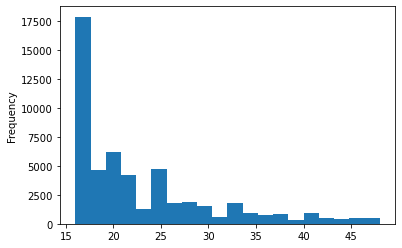

In [128]:
lens.Lengths[(lens.Lengths >= 16) & (lens.Lengths <= 48)].plot.hist(bins = 20);

In [ ]:
seqs = []
arry = [1,2,3,4,5,6,7,8,9]
arr = np.array([1,2,3,40,5,60,70,8])
bools = arr > 10
splits = list(compress(range(len(bools)), bools))
splits = [x+1 for x in splits]
s = splits + [len(arry)]
seqs.append([np.array(arry[i1:i2]) for i1,i2 in zip([0]+s[:-1], s)])
seqs

[[array([1, 2, 3, 4]), array([5, 6]), array([7]), array([8, 9])]]

In [ ]:
seqs2 = []
arry = [1,2,3,4,5,6,7,8,9]
arr = np.array([1,2,3,40,5,60,70,8])
bools = arr > 10
splits = list(compress(range(len(bools)), bools))
splits = [x+1 for x in splits]
s = splits + [len(arry)]
seqs2.append([np.array(arry[i1:i2]) for i1,i2 in zip([0]+s[:-1], s)])
seqs2

In [ ]:
seqss = np.concatenate((seqs[0], seqs2[0]))
seqss

In [ ]:
seqss = np.concatenate((seqss, seqs[0]))
seqss

## Data Organization

In [200]:
from datetime import datetime
from itertools import compress

# need to add paired array containing returns or quits boolean

# heads up, this cell takes like 30 mins to run...

# define hyperparameters
idle = 264309462898.15878
idle = 100000000000 # for experimentation purposes
quit = 1008440562827.623

#current_time = datetime.now()
current_time = datetime.strptime('2022-12-31 23:59:59.999', '%Y-%m-%d %H:%M:%S.%f')

seqs = []
class_time_seqs = []
pred_time_seqs = []
class_labels = []
for user in users_subset[:100000]:
    # get event timestamps
    event_times = user_seqs.get_group(user).CREATED
    # get event sequence
    event_seq = list(user_seqs.get_group(user).EVENT)
    
    # compute the time gaps between events
    diff_list = []
    for x, y in zip(event_times[0::], event_times[1::]):
        xt = datetime.strptime(' '.join(x.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        yt = datetime.strptime(' '.join(y.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        diff_list.append(yt-xt)
    diff_list = np.array(diff_list, dtype='timedelta64[us]').astype(float)
    
    # find where idles occur
    idle_bool = diff_list > idle
    idle_indices = list(compress(range(len(idle_bool)), idle_bool))
    
    # break whole time gaps sequence into subsequences
    class_time_split = np.split(diff_list, idle_indices)
    [class_time_seqs.append(item) for item in class_time_split]
    idle_indices = [x+1 for x in idle_indices]
    pred_time_split = np.split(diff_list, idle_indices)
    [pred_time_seqs.append(item) for item in pred_time_split]
    
    # break whole event sequence into subsequences (convert this into the np.split form)
    #temp = []
    #s = idle_indices + [len(event_seq)]
    #temp.append([event_seq[i1:i2] for i1,i2 in zip([0]+s[:-1], s)])
    # store subsequences in seqs array
    #[seqs.append(np.array(item, dtype=object)) for item in temp[0]]
    event_split = np.split(event_seq, idle_indices)
    [seqs.append(item) for item in event_split]
    
    x = event_times.iloc[-1]
    end_gap = current_time - datetime.strptime(' '.join(x.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
    end_gap = np.array(end_gap, dtype='timedelta64[us]').astype(float)
    # determine subsequence class labels
    if len(class_time_split) > 1:
        [class_labels.append(1) for i in range(len(class_time_split)-1)]
    if end_gap > quit:
        class_labels.append(0)
    else:
        class_labels.append(2)
    
# covert lists into arrays
class_time_seqs = np.array(class_time_seqs, dtype=object)
pred_time_seqs = np.array(pred_time_seqs, dtype=object)
seqs = np.array(seqs, dtype=object)
class_labels = np.array(class_labels)

In [201]:
min_length_bool = length_checker(class_time_seqs) >= 12

In [206]:
train_class_time_seqs = class_time_seqs[min_length_bool]
#train_class_time_seqs

In [207]:
train_class_labels = class_labels[min_length_bool]
#train_class_labels

In [208]:
print(len(train_class_time_seqs))
print(len(train_class_labels))

5424
5424


In [209]:
labels = pd.DataFrame({'Labels': train_class_labels})
labels.Labels.value_counts().sort_index()

0    2363
1    2864
2     197
Name: Labels, dtype: int64

In [212]:
min_length_bool = length_checker(pred_time_seqs) >= 12
train_pred_time_seqs = pred_time_seqs[min_length_bool]
len(train_pred_time_seqs)

5469

## Preliminary Prediction Model

In [213]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

2023-01-29 14:20:58.213652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [214]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
train_data, test_data, data = get_train_test(sunspots_url)